# <center>Setup ORBIT</center>

In [5]:
import pandas as pd
from ORBIT import ProjectManager, load_config
from construction_finance_param import con_fin_params
import matplotlib.pyplot as plt
# Path to save plots and other data:
path = '/Users/pbhaskar/Desktop/cowe2022/osw_floating/'

# <center> Load and check the project configuration</center>

In [6]:
floating_config = load_config("COE_2020_floating_project.yaml") 

print(f"Num turbines: {floating_config['plant']['num_turbines']}")
print(f"Turbine: {floating_config['turbine']}")
print(f"\nSite: {floating_config['site']}")
print(f"\nDesign phases: {floating_config['design_phases']}")
print(f"\nInstall phases: {list(floating_config['install_phases'].keys())}")

Num turbines: 75
Turbine: COE_2020_8MW

Site: {'depth': 739, 'distance': 189, 'distance_to_landfall': 36}

Design phases: ['ArraySystemDesign', 'ExportSystemDesign', 'MooringSystemDesign', 'OffshoreSubstationDesign', 'SemiSubmersibleDesign']

Install phases: ['ArrayCableInstallation', 'ExportCableInstallation', 'MooredSubInstallation', 'MooringSystemInstallation', 'OffshoreSubstationInstallation']


# <center> Run </center>

In [9]:
project = ProjectManager(floating_config)
d = 0.3 # includes 30% downtime factor during construction to match ORCA
project.run(availability=1-d)

# <center> Top Level Outputs </center>

In [10]:
print(f"Installation CapEx:  {project.installation_capex_per_kw:.2f}")
print(f"System CapEx:        {project.system_capex_per_kw:.2f}")
print(f"BOS CapEx:           {project.bos_capex_per_kw:.2f}")
print(f"Turbine CapEx:       {project.turbine_capex_per_kw:.2f}")

Installation CapEx:  550.11
System CapEx:        2368.32
BOS CapEx:           2918.43
Turbine CapEx:       1300.00


In [24]:
dct = project.capex_breakdown_per_kw
dct = {k:[v] for k,v in dct.items()}
df = pd.DataFrame.from_dict(dct, orient="columns")

soft_dct = con_fin_params(bos=project.bos_capex, 
               turbine_capex=project.turbine_capex,
               orbit_install_capex=project.installation_capex,
               plant_cap=600000)

for k,v in soft_dct.items():
    if k != "soft_capex":
        df[k] = v
    else:
        df["Soft"] = v
df = df.T
df.to_csv("COE_floating_result.csv")

project.capex_breakdown_per_kw
x = project.phases["SemiSubmersibleDesign"]
x.detailed_output
print(project.installation_costs)
print(project.system_costs)
print(project.bos_capex)

# print(project.__dict__)

{'ArrayCableInstallation': 30234732.265915655, 'ExportCableInstallation': 114461871.54621631, 'MooredSubInstallation': 87186344.1780822, 'MooringSystemInstallation': 90576834.63796481, 'OffshoreSubstationInstallation': 7607263.362687541}
{'ArrayCableInstallation': 71886065.39866768, 'ExportCableInstallation': 75794538.60938, 'MooredSubInstallation': 760414296.9, 'MooringSystemInstallation': 413419110.492305, 'OffshoreSubstationInstallation': 99479100.0}
1751060157.3912191


# <center> Phase Specific Outputs </center>

In [19]:
print(f"Substructure Installation:  {project.phases['MooredSubInstallation'].installation_capex/1e6:.0f} M")
print(f"Substructure Procurement:  {project.phases['MooredSubInstallation'].system_capex/1e6:.0f} M")

print(f"Mooring System Installation:   {project.phases['MooringSystemInstallation'].installation_capex/1e6:.0f} M")
print(f"Mooring System Procurement:   {project.phases['MooringSystemInstallation'].system_capex/1e6:.0f} M")

print(f"Array System Installation: {project.phases['ArrayCableInstallation'].installation_capex/1e6:.0f} M")
print(f"Array System Procurement:  {project.phases['ArrayCableInstallation'].system_capex/1e6:.0f} M")

Substructure Installation:  87 M
Substructure Procurement:  760 M
Mooring System Installation:   91 M
Mooring System Procurement:   413 M
Array System Installation: 30 M
Array System Procurement:  72 M


# <center> Installation Actions </center>

In [17]:
d = pd.DataFrame(project.actions)
c = d.groupby('phase')
print(c['duration'].sum()/24)

da = pd.DataFrame(project.actions)
ca = da.groupby('action')
print(ca['duration'].sum()/24)

phase
ArrayCableInstallation             164.799075
ExportCableInstallation             26.688444
MooredSubInstallation             1887.000000
MooringSystemInstallation          549.232143
OffshoreSubstationInstallation      25.220810
Name: duration, dtype: float64
action
ActiveFeeder                                  2.808321
Attach Topside                                0.714286
Ballast to Operational Draft                 26.785714
Ballast to Towing Draft                      18.750000
Bolt TP                                       0.476190
Check Mooring Lines                          53.571429
Connect Mooring Lines                        98.214286
Crane Reequip                                 0.238095
Delay                                       215.875000
Delay: No Completed Assemblies Available     11.062500
Delay: No Substructures in Wet Storage      232.500000
Drive Monopile                                0.178571
Fasten Monopile                               1.428571
Fasten Tops

<br/><br/>
# <center>Assign Variables to ORBIT Calculated Values</center>

In [28]:
# Capex: 5351
capex = 5351

# Turbine: 1021 $/kW
turbine_capex_kW = project.turbine_capex_per_kw
# print(turbine_capex_kW)

# BOS : 3234 $/kW
development_kW = 0.016 * capex   #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
substructure_foundation_kW = dct['Substructure'][0]
electrical_infrastructure_kW = 0.127 * capex  #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
assembly_installation_kW = 0.057 * capex  #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
lease_price_kW = 0.032 * capex    #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
bos_capex_kW = lease_price_kW + assembly_installation_kW + electrical_infrastructure_kW + substructure_foundation_kW + development_kW


# print(soft_dct['decomissioning_costs'])
# Soft Costs
plant_commissioning_kW = 0.009 * capex    #<><><><><><><> Not in CAPEX breakdown <><><><><><><>
decommissioning_kW = soft_dct['decomissioning_costs']
contingency_kW = soft_dct['procurement_contingency_costs'] = soft_dct['install_contingency_costs']
construction_finance_kW = soft_dct['construction_financing']
insurance_during_construction_kW = soft_dct['construction_insurance_capex']
soft_costs_kW = insurance_during_construction_kW + \
                construction_finance_kW + \
                contingency_kW + \
                decommissioning_kW + \
                plant_commissioning_kW
    

# O&M
o_and_m_kW = 0.336 * capex



<br/><br/>
# <center>Figure ES3. Component-level LCOE contribution for the 2020 fixed-bottom offshore wind reference project operating for 25 years</center>

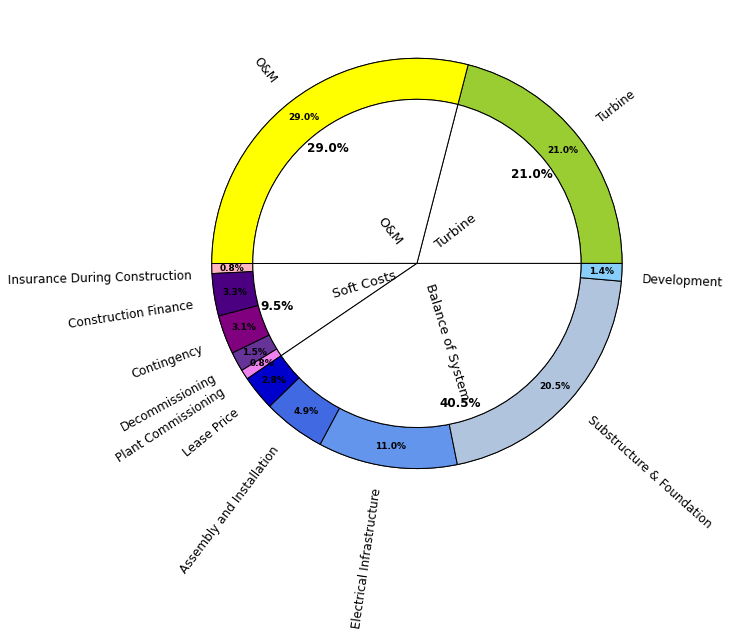

In [33]:
# Plot
start_angle = 0
plt.figure(figsize=(10,10))
names = ['Turbine',
         
         'O&M',
         
         'Insurance During Construction',            # 
         'Construction Finance',   #
         'Contingency',
         'Decommissioning',
         'Plant Commissioning',
         
         'Lease Price',
         'Assembly and Installation',
         'Electrical Infrastructure',
         'Substructure & Foundation',
         'Development']              #

sub_colors = ['yellowgreen',
              
              'yellow', 
              
              'lightpink',
              'indigo',
              'purple', 
              'rebeccapurple', 
              'violet',
              
              'mediumblue',
              'royalblue', 
              'cornflowerblue',
              'lightsteelblue', 
              'lightskyblue']

size = [turbine_capex_kW, 
        
        o_and_m_kW,
        
        insurance_during_construction_kW, 
        construction_finance_kW, 
        contingency_kW,
        decommissioning_kW,
        plant_commissioning_kW,
        
        lease_price_kW,
        assembly_installation_kW, 
        electrical_infrastructure_kW,
        substructure_foundation_kW,
        development_kW]

# Plot

# Internal Pies
sub_names = ['Turbine', 'O&M', 'Soft Costs', 'Balance of System']

a = 'white'
sub_size = [turbine_capex_kW, o_and_m_kW, soft_costs_kW, bos_capex_kW]

plt.pie(size, 
        labels = names, 
        startangle=start_angle,
        colors = sub_colors,
        rotatelabels=True,
        radius= 1.0, 
        labeldistance=1.1,
        textprops ={'fontsize':12, 'color': "black"},
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black" }) 

no_color = 'w'
plt.pie(size, 
#         labels = names, 
        startangle=start_angle,
        autopct = '%1.1f%%', 
        rotatelabels=True,
        pctdistance = 0.9,
#         colors = [no_color],
        colors = sub_colors,
        radius= 1.0, 
#         labeldistance=1.1,
        textprops={'fontweight': 'bold', 
                   'fontsize':9, 
                   'color': "black"},
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black" }) 



# Internal Pies
plt.pie(sub_size,
        autopct = '%1.1f%%', 
        pctdistance = 0.89,
        rotatelabels=True,
        startangle=start_angle, 
        radius= 0.80, 
        textprops ={
            'fontweight': 'bold' ,
            'fontsize':12, 
            'color': "black"}, 
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black" } )

plt.pie(sub_size,
        startangle=start_angle, 
        labeldistance =0.12, 
        labels = sub_names,
        rotatelabels=True,
        radius= 0.80, 
        colors=[a, a, a],
        # Labeling for internal pie chart (Turbine, BOS, Financial)
        textprops ={'fontsize':13, 'color': "black"}, 
        wedgeprops = {'linewidth' : 1, 'edgecolor' : "black" } )



# show it
# plt.update_traces()
# plt.legend()
plt.tight_layout()
plt.savefig(path + 'fig_es3.eps', format='eps', dpi=1000)
plt.show()




<br/><br/>
# <center>Figure ES7.  Fixed-bottom offshore wind power plant assumption and ranges for key LCOE input parameters

In [36]:
# Tornado chart template obtained from 
# https://python.plainenglish.io/how-to-create-a-beautify-tornado-chart-in-python-plotly-6c0519e185b4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

lcoe = 129    # $/MWh
y_labels = ['Project Design Life (years)',
         'Discount Rate (nominal) [%]',
         'Net Capacity Factor (%)',
         'OpEx ($/kW/yr)',
         'CapEx ($/kW)']


upper_capex = 145
upper_opex = 150
upper_net_cf = 140
upper_discount_rate = 142
upper_project_design_life = 175
upper_bound = [upper_project_design_life, 
               upper_discount_rate, 
               upper_net_cf,
               upper_opex,
               upper_capex]

# Values to go into bar labels
upper_capex_label = 6059
upper_opex_label = 177
upper_net_cf_label = 35
upper_discount_rate_label = 6.61
upper_project_design_life_label = 15
upper_bound_label = [upper_project_design_life_label, 
                    upper_discount_rate_label, 
                    upper_net_cf_label,
                    upper_opex_label,
                    upper_capex_label]

# ajdust for lcoe 
upper_bound_lcoe_adjustment = [x - lcoe for x in upper_bound]

lower_capex = lcoe - 68
lower_opex = lcoe - 110
lower_net_cf = lcoe - 95
lower_discount_rate = lcoe - 115
lower_project_design_life = lcoe - 110
lower_bound = [lower_project_design_life, 
               lower_discount_rate, 
               lower_net_cf,
               lower_opex,
               lower_capex]

# Values to go into bar labels
lower_capex_label = 2045
lower_opex_label = 59
lower_net_cf_label = 50.0
lower_discount_rate_label = 3.97
lower_project_design_life_label = 35
lower_bound_label = [lower_project_design_life_label, 
                    lower_discount_rate_label, 
                    lower_net_cf_label,
                    lower_opex_label,
                    lower_capex_label]

# Values for reference case
base_capex = 0.001
base_opex = 0.001
base_net_cf = 0.001
base_discount_rate = 0.001
base_project_design_life = 0.001
base_bound = [base_project_design_life, 
               base_discount_rate, 
               base_net_cf,
               base_opex,
               base_capex]

# Values to go into bar labels (reference)
base_capex_label = 5351
base_opex_label = 118
base_net_cf_label = 38
base_discount_rate_label = 5.29
base_project_design_life_label = 25
base_bound_label = [base_project_design_life_label, 
                    base_discount_rate_label, 
                    base_net_cf_label,
                    base_opex_label,
                    base_capex_label]

#convert lower_bound to negative values
def Convert(lst):
    return [ -i for i in lst ]

negative_lower_bound = Convert(lower_bound)
# ajdust for lcoe 
negative_lower_bound_lcoe_adjustment = [x + lcoe for x in negative_lower_bound]

fig = go.Figure()



customscale=["rgb(51,153,255)",
            "rgb(102, 166, 30)",
            "rgb(230, 131, 16)", 
            "rgb(153, 153, 153)",
            "rgb(51, 34, 136)"]
z = customscale

fig.add_trace(go.Bar(y=y_labels, x=upper_bound_lcoe_adjustment,
                base=lcoe,
                marker=dict(color = z, colorscale=customscale),
                orientation='h',
                marker_line_width=1.5,
                text = [round(elem, 1) for elem in upper_bound_label],
                textposition='auto',
                textfont=dict(color="white")
                    ))

fig.add_trace(go.Bar(y=y_labels, x=base_bound,
                base= lcoe,
                marker=dict(color = z, colorscale=customscale),
                orientation='h',
                text = [round(elem, 1) for elem in base_bound_label],
                textposition='auto',
                textfont=dict(color="white")
              ))

fig.add_trace(go.Bar(y=y_labels, x=negative_lower_bound,
                base= lcoe,
                marker=dict(color = z, colorscale=customscale),
                orientation='h',
                text = [round(elem, 1) for elem in lower_bound_label],
                textposition='inside',
                textfont=dict(color="white")
              ))

fig.update_layout(height=500,
                  margin=dict(t=50,l=10,b=10,r=10),title_text="Land-based wind power plant assumptions and ranges for key LCOE input parameters",
                  title_font_family="sans-serif",
                  title_font_size = 25,
                  title_font_color="black",
                  title_x=0.5 #to adjust the position along x-axis of the title
                 )

fig.update_layout(
                  barmode='overlay', 
                  xaxis_tickangle=-45, 
                  xaxis=dict(
                      title="Leveleized Cost of Electricity [Reference LCOE = $" + str(lcoe) +  "/MWh]"),
                  yaxis=dict(
                             title='Key Parameters for LCOE Sensitivity Analysis', 
                             titlefont_size=16, 
                             tickfont_size=14),
                  bargap=0.30, 
                  paper_bgcolor='white',
                  plot_bgcolor='white',
                 )
fig.update(layout_showlegend=False)
# fig.savefig(path + 'fig_es6.eps', format='eps', dpi=1000)
fig.write_image(path + 'fig_es7.eps', scale=1, width=1000, height=800)
fig.show()

<br/><br/>
# <center> Initial FLoating Estimate (GPRA) </center>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

gpra_y = []
gpra_x = [2019, 2030]

actuals_y = []
actuals_x = [2016, 2017, 2018, 2019, 2020, 2021, 2022]

plt.plot(gpra_x, gpra_y, 
         linestyle='-', 
         marker='o', 
         color='skyblue', 
         markerfacecolor='black', 
         markeredgecolor='black', 
         label='GRPA Trajectory')

plt.plot(actuals_x, 
         actuals_y, 
         linestyle='-', 
         marker='d', 
         markerfacecolor='black', 
         markeredgecolor='black', 
         color='green', 
         label='Actual Reported Data')

max_y = [*gpra_y, *actuals_y]

plt.xlabel('Fiscal Year', fontweight='bold')
plt.ylabel('LCOE (2015$/MWh)', fontweight='bold')

for index in range(len(actuals_x)):
  label = "{:.1f}".format(actuals_y[index])
  plt.annotate(label, 
                 (actuals_x[index],actuals_y[index]), 
                 textcoords="offset points", 
                 xytext=(0,-15), 
                 ha='center', 
                 size=8) 

for index in range(len(gpra_x)):
  label = "{:.1f}".format(gpra_y[index])
  plt.annotate(label, 
                 (gpra_x[index],gpra_y[index]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 size=8) 
plt.legend()
plt.ylim([0, (max(max_y) + 5)])
plt.savefig(path + 'fig_7.eps', format='eps', dpi=1000)
plt.show()